# Breast Cancer Histopathology Images Classifier

Neural network model for binary classification of Invasive Ductal Carcinoma (IDC) cancer in histopathology images from kaggle database https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images (licence : CC0: Public Domain). 

## Dataset structure
Dataset contains 277,524 patches of size 50 x 50 from histopathology images. 
Dataset is divided into 279 folders. Each folder contains 2 folders: one named "0" with patches classified as non-IDC tissue and one named "1" with patches classified as IDC tissue. 

Patches have following file format: u_xX_yY_classC.png, where u is patient ID, X is x coordinate, Y is y coordinate and C is a class (0 or 1).
Example: 8863_idx5_x51_y1251_class0.png

## Import modules

In [8]:
import cv2
import tensorflow as tf
import tensorflow_datasets as tfds
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import shutil
import zipfile

## Download dataset

In [9]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

Kaggle API token is necessary for downloading Kaggle dataset. A link to instruction on how to download a token : https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [7]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.09G/3.10G [00:19<00:00, 291MB/s]
100% 3.10G/3.10G [00:19<00:00, 168MB/s]


In [10]:
zip_ref = zipfile.ZipFile('breast-histopathology-images.zip', 'r')
zip_ref.extractall('/content/images')
zip_ref.close()

In [11]:
!rm -r /content/images/IDC_regular_ps50_idx5

In [12]:
data_path = '/content/images/'

## Load images of tissues from one patient

In [13]:
image_files_0 = []
image_files_1 = []
image_files_0 = glob(data_path + '/' + '8863' + '/0/*.png')
image_files_1 = glob(data_path + '/' + '8863' + '/1/*.png')
for image_file in image_files_0[0:5]:
  print(image_file)
for image_file in image_files_1[0:5]:
  print(image_file)

/content/images//8863/0/8863_idx5_x501_y1401_class0.png
/content/images//8863/0/8863_idx5_x301_y551_class0.png
/content/images//8863/0/8863_idx5_x1851_y1901_class0.png
/content/images//8863/0/8863_idx5_x1351_y1301_class0.png
/content/images//8863/0/8863_idx5_x851_y851_class0.png
/content/images//8863/1/8863_idx5_x1051_y1651_class1.png
/content/images//8863/1/8863_idx5_x1601_y1601_class1.png
/content/images//8863/1/8863_idx5_x1251_y1451_class1.png
/content/images//8863/1/8863_idx5_x1001_y851_class1.png
/content/images//8863/1/8863_idx5_x1601_y1501_class1.png


In [14]:
print(len(image_files_0))
print(len(image_files_1))

772
207


In [15]:
def load_x_y_from_path(image_files_0, image_files_1):
  x = []
  neg_images = []
  pos_images = []
  y = []

  for image_file in image_files_0:
      image = cv2.imread(image_file)
      image = cv2.resize(image, (50,50))
      y.append(0)
      x.append(image)
      neg_images.append(image)

  for image_file in image_files_1:
      image = cv2.imread(image_file)
      image = cv2.resize(image, (50,50))
      y.append(1)
      x.append(image)
      pos_images.append(image)
    
  return x, y, neg_images, pos_images

x, y, neg_images, pos_images = load_x_y_from_path(image_files_0, image_files_1)

## Show images

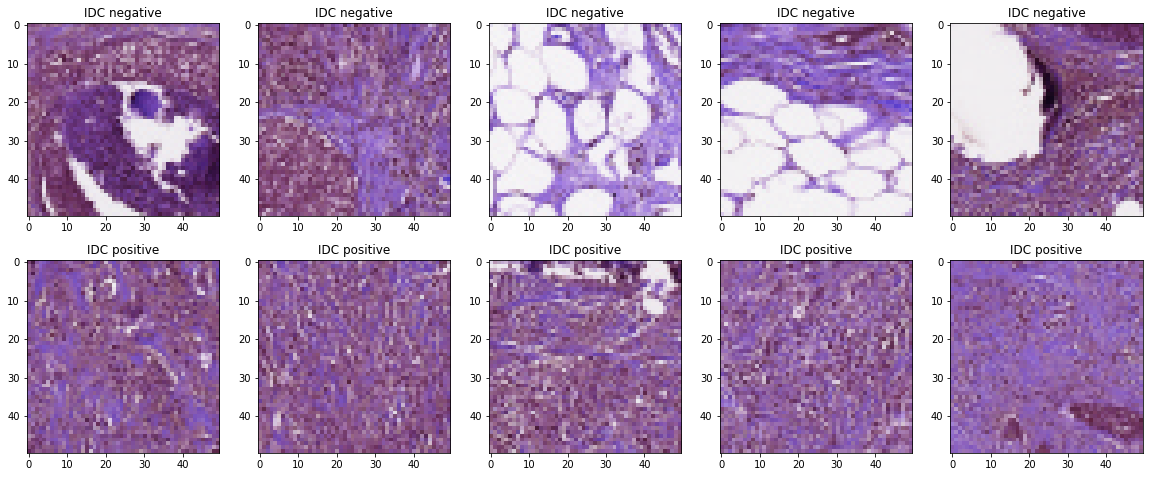

In [16]:
def plot_neg_pos(neg_images,pos_images):
  plt.figure(figsize = (20,8))
  k = 5
  for i, neg_image in enumerate(random.choices(neg_images,k=k)):
    plt.subplot(2,k,i+1)
    plt.title('IDC negative')
    plt.imshow(neg_image)

  for i, pos_image in enumerate(random.choices(pos_images,k=k)):
    plt.subplot(2,k,i+1+k)
    plt.title('IDC positive')
    plt.imshow(pos_image)
    
plot_neg_pos(neg_images,pos_images)

## Prepare folder structure for tfds.folder_dataset.ImageFolder
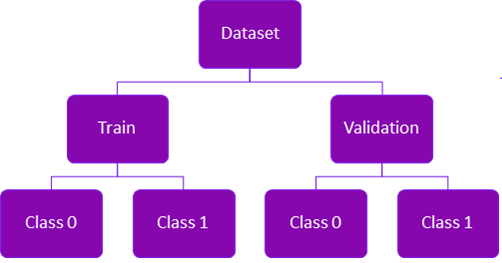

In [17]:
train_val_folders = [os.path.basename(x) for x in glob(data_path + '*')]
print(train_val_folders[0:5])
print(len(train_val_folders))

['10277', '9225', '12898', '16896', '10293']
279


In [18]:
!mkdir -p ./dataset/train/0
!mkdir -p ./dataset/train/1
!mkdir -p ./dataset/val/0
!mkdir -p ./dataset/val/1 

In [19]:
for folder in train_val_folders:
  files = os.listdir(data_path + folder + "/0")
  for file_name in files:
    shutil.copy(src = data_path + folder + "/0/" + file_name, dst = "./dataset/train/0")    

for folder in train_val_folders:
  files = os.listdir(data_path + folder + "/1")
  for file_name in files:
    shutil.copy(src = data_path + folder + "/1/" + file_name, dst = "./dataset/train/1")

files = os.listdir("./dataset/train/0")
random.shuffle(files)
for file_name in files[0:len(files)//10]:
    shutil.move(src = "./dataset/train/0/" + file_name, dst = "./dataset/val/0/")

files = os.listdir("./dataset/train/1")
random.shuffle(files)
for file_name in files[0:len(files)//10]: 
    shutil.move(src = "./dataset/train/1/" + file_name, dst = "./dataset/val/1/")

## Dataset

In [20]:
builder = tfds.ImageFolder("./dataset")
print(builder.info) 

tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=277524,
    splits={
        'train': 249773,
        'val': 27751,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



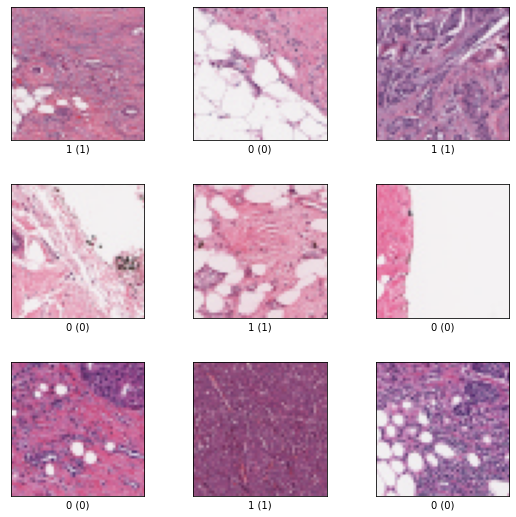

In [21]:
train_data = builder.as_dataset(split='train',as_supervised=True, shuffle_files=True)
val_data = builder.as_dataset(split='val',as_supervised=True, shuffle_files=True)

fig = tfds.show_examples(train_data, builder.info)
plt.show()

## Preprocess and split to train and validation

In [22]:
def preprocess_images(image, label):
  image = tf.image.resize(image, [50,50])
  image = tf.cast(image, tf.float32)
  image = image/255.0
  return image, label

train_prep = train_data.map(preprocess_images, num_parallel_calls = tf.data.AUTOTUNE)
train_prep = train_prep.cache('/tmp/train_cache')
train_batches = train_prep.batch(128).prefetch(tf.data.AUTOTUNE)

val_prep = val_data.map(preprocess_images)
val_prep = val_prep.cache('/tmp/val_cache')
val_batches = val_prep.batch(128).prefetch(tf.data.AUTOTUNE)

## Balance dataset

In [23]:
y_train = [int(item[1]) for item in train_prep]

In [24]:
cw = class_weight.compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)
cw_dict = {0:cw[0], 1:cw[1]}
print(cw_dict)

{0: 0.6982165320213569, 1: 1.7612469679020704}


## Create Model

In [25]:
model = keras.models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(50, 50, 3)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu',),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 19, 19, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 32)         0         
 2D)                                                    

In [26]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Callbacks

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
model_checkpoint= ModelCheckpoint('best_model', save_best_only=True, monitor='val_loss', mode='min')

## Training

In [28]:
history=model.fit(train_batches, epochs=50, class_weight =cw_dict, validation_data=val_batches, verbose=1,shuffle=False, callbacks=[early_stopping, model_checkpoint],use_multiprocessing=True)

Epoch 1/50
1952/1952 [==============================] - ETA: 0s - loss: 0.4598 - accuracy: 0.7993INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1952/1952 [==============================] - 74s 32ms/step - loss: 0.4598 - accuracy: 0.7993 - val_loss: 0.4044 - val_accuracy: 0.8259
Epoch 2/50
1950/1952 [============================>.] - ETA: 0s - loss: 0.4152 - accuracy: 0.8170INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1952/1952 [==============================] - 34s 18ms/step - loss: 0.4151 - accuracy: 0.8170 - val_loss: 0.3803 - val_accuracy: 0.8403
Epoch 3/50
1950/1952 [============================>.] - ETA: 0s - loss: 0.3935 - accuracy: 0.8291INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1952/1952 [==============================] - 34s 18ms/step - loss: 0.3935 - accuracy: 0.8292 - val_loss: 0.3781 - val_accuracy: 0.8433
Epoch 4/50
1949/1952 [============================>.] - ETA: 0s - loss: 0.3797 - accuracy: 0.8364INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1952/1952 [==============================] - 34s 18ms/step - loss: 0.3796 - accuracy: 0.8365 - val_loss: 0.3647 - val_accuracy: 0.8475
Epoch 5/50
1949/1952 [============================>.] - ETA: 0s - loss: 0.3717 - accuracy: 0.8397INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1952/1952 [==============================] - 44s 23ms/step - loss: 0.3716 - accuracy: 0.8397 - val_loss: 0.3436 - val_accuracy: 0.8560
Epoch 6/50
1952/1952 [==============================] - 146s 75ms/step - loss: 0.3653 - accuracy: 0.8431 - val_loss: 0.3529 - val_accuracy: 0.8517
Epoch 7/50
1952/1952 [==============================] - 184s 94ms/step - loss: 0.3626 - accuracy: 0.8436 - val_loss: 0.3777 - val_accuracy: 0.8398
Epoch 8/50
1952/1952 [==============================] - 167s 85ms/step - loss: 0.3587 - accuracy: 0.8454 - val_loss: 0.3770 - val_accuracy: 0.8434
Epoch 9/50
1952/1952 [==============================] - 184s 94ms/step - loss: 0.3561 - accuracy: 0.8464 - val_loss: 0.3632 - val_accuracy: 0.8492
Epoch 10/50
1952/1952 [==============================] - 184s 94ms/step - loss: 0.3503 - accuracy: 0.8483 - val_loss: 0.3639 - val_accuracy: 0.8450
Epoch 11/50
1952/1952 [==============================] - 185s 95ms/step - loss: 0.3468 - accuracy: 0.8502 - val_loss: 0.3538 - va

## Model evaluation

### Loss and Accuracy Graph

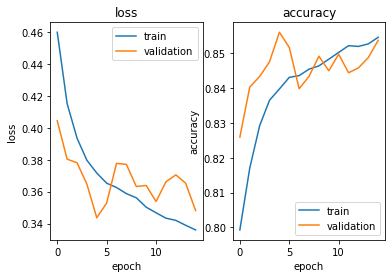

In [29]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(history.history['loss'], label = "train")
ax[0].plot(history.history['val_loss'], label = "validation")

ax[1].plot(history.history['accuracy'], label = "train")
ax[1].plot(history.history['val_accuracy'], label = "validation")

ax[0].set_xlabel("epoch")
ax[1].set_xlabel("epoch")

ax[0].set_ylabel("loss")
ax[1].set_ylabel("accuracy")

ax[0].set_title("loss")
ax[1].set_title("accuracy")

ax[0].legend() 
ax[1].legend() 

### Load best model


In [30]:
model = tf.keras.models.load_model('best_model')

In [31]:
x_val = [item[0] for item in val_prep]
y_val = [int(item[1]) for item in val_prep]

### Loss and Accuracy

In [32]:
best_model_loss, best_model_accuracy = model.evaluate(val_batches)
print("Best model loss: ","{:.4f}".format(best_model_loss),"Best model accuracy: ","{:.2%}".format(best_model_accuracy))

217/217 [==============================] - 2s 7ms/step - loss: 0.3436 - accuracy: 0.8560
Best model loss:  0.3436 Best model accuracy:  85.60%


### Confusion Matrix
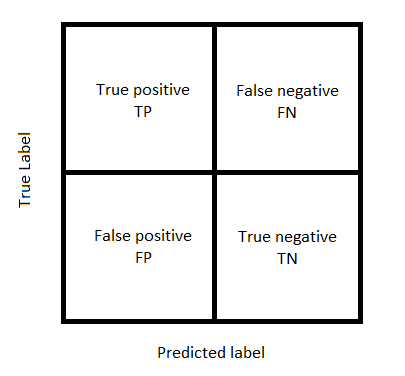

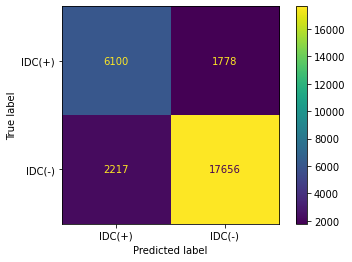

In [33]:
pred_val = np.argmax(model.predict(val_batches),axis=1)
cm = confusion_matrix(y_val, pred_val, labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['IDC(+)','IDC(-)'])
disp.plot()
plt.show()

### F-score - harmonic mean of precision and sensitivity
$F_1 = \frac{TP}{TP+\frac{1}{2}(FP+FN)}$

In [34]:
print("F-score: ","{:.2%}".format(f1_score(y_val, pred_val)))

F-score:  75.33%


## Balanced accuracy - mean of sensitivity and specificity
$Balanced\_Accuracy = \frac{1}{2}(\frac{TP}{TP+FN}+\frac{TN}{TN+FP})$


In [35]:
print('Balanced Accuracy: ', "{:.2%}".format(balanced_accuracy_score(y_val, pred_val)))

Balanced Accuracy:  83.14%


Both F-score and balanced accuracy are comparable to values obtained in paper "Automatic detection of invasive ductal carcinoma in whole slide images with Convolutional Neural Networks" (Cruz-Roa et al., 2014) - respectively 71.80% and 84.23%.

https://doi.org/10.1117/12.2043872

### Analysis of incorectly classified images
Numerous incorectly classified images contain very little visible tissue or include mosty fat cells.

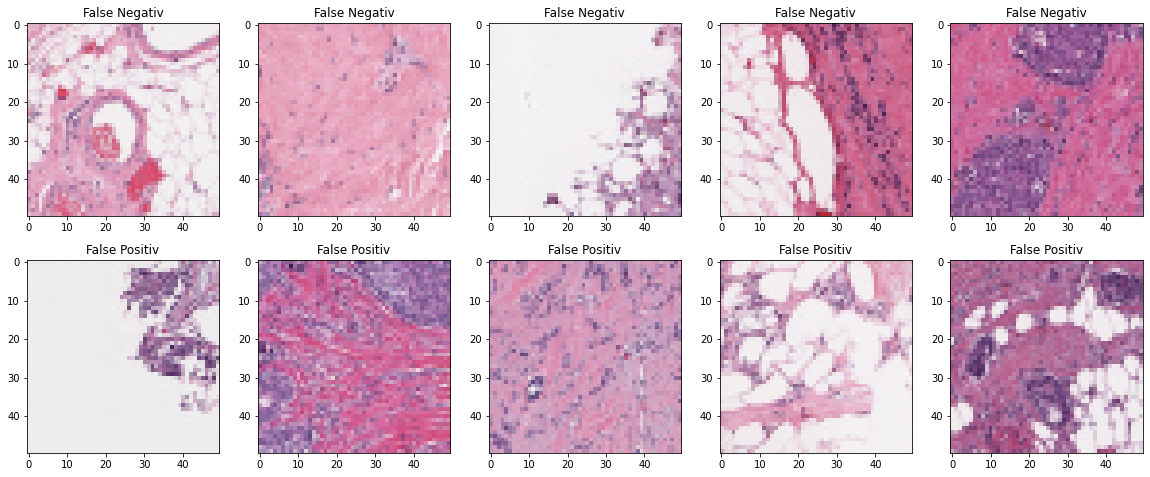

In [36]:
def plot_fn_fp(false_neg,false_pos):
  plt.figure(figsize = (20,8))
  k = 5
  for i, neg_image in enumerate(random.choices(false_neg,k=k)):
    plt.subplot(2,k,i+1)
    plt.title('False Negativ')
    plt.imshow(neg_image)

  for i, pos_image in enumerate(random.choices(false_pos,k=k)):
    plt.subplot(2,k,i+1+k)
    plt.title('False Positiv')
    plt.imshow(pos_image)

false_neg = [image for image,label,pred_label in zip(x_val,y_val,pred_val) if label==1 and pred_label == 0]
false_pos = [image for image,label,pred_label in zip(x_val,y_val,pred_val) if label==0 and pred_label == 1]  

plot_fn_fp(false_neg,false_pos)